In [1]:
from pyscf import gto, scf, ao2mo, fci
import numpy as np

# --- 1. Define H2 Molecule ---
# H2 at roughly equilibrium bond length (0.735 Angstroms)
mol = gto.Mole()
mol.build(
    atom = 'H 0 0 0; H 0 0 0.735',
    basis = '6-31g',    # This basis gives 4 spatial orbitals for H2
    spin = 0,
    charge = 0,
    verbose = 0
)

# --- 2. Run classical Hartree-Fock to get Molecular Orbitals ---
mf = scf.RHF(mol)
mf.kernel()

# --- 3. Extract system parameters for SQD ---
num_orbitals = mol.nao_nr()
num_alpha, num_beta = mol.nelec
nuclear_repulsion_energy = mol.energy_nuc()
spin_sq = 0
open_shell = False

# --- 4. Get Molecular Integrals (Hamiltonian) ---
# Core Hamiltonian (one-electron integrals) in Molecular Orbital basis
core_hamiltonian = mf.mo_coeff.T @ mf.get_hcore() @ mf.mo_coeff

# Electron Repulsion Integrals (two-electron integrals) in Molecular Orbital basis
# We restore it to '1' (full 4-tensor symmetry) to match the input expected by the original notebook
eri_mo = ao2mo.kernel(mol, mf.mo_coeff)
electron_repulsion_integrals = ao2mo.restore(1, eri_mo, num_orbitals)

# --- 5. Calculate exact energy for later comparison ---
# We calculate the exact Full Configuration Interaction (FCI) energy now
# so we don't have to hardcode it later.
cisolver = fci.FCI(mf)
exact_energy = cisolver.kernel()[0]

print("H2 Molecule prepared successfully.")
print(f"System: {num_orbitals} Orbitals, {num_alpha} alpha electrons, {num_beta} beta electrons.")
print(f"Target Exact Energy: {exact_energy:.6f} Ha")

H2 Molecule prepared successfully.
System: 4 Orbitals, 1 alpha electrons, 1 beta electrons.
Target Exact Energy: -1.151614 Ha


In [2]:
from qiskit_addon_sqd.counts import generate_counts_uniform
from qiskit_addon_sqd.counts import counts_to_arrays
import numpy as np

# Set a seed for reproducibility
rng = np.random.default_rng(42)

# Generate 10,000 fake random shots for our 8-qubit system (2 * num_orbitals)
counts = generate_counts_uniform(10_000, num_orbitals * 2, rand_seed=rng)

# Convert counts into bitstring and probability arrays required by SQD
bitstring_matrix_full, probs_array_full = counts_to_arrays(counts)
print("Simulated random samples generated.")

Simulated random samples generated.


In [3]:
# --- SQD options ---
ITERATIONS = 5
NUM_BATCHES = 1
# A smaller batch size is sufficient for this small H2 system
SAMPLES_PER_BATCH = 100
MAX_DAVIDSON_CYCLES = 200

# Initialize history trackers
energy_hist = np.zeros((ITERATIONS, NUM_BATCHES))
spin_sq_hist = np.zeros((ITERATIONS, NUM_BATCHES))
occupancy_hist = []
avg_occupancy = None

from qiskit_addon_sqd.configuration_recovery import recover_configurations
from qiskit_addon_sqd.subsampling import postselect_and_subsample
from qiskit_addon_sqd.fermion import bitstring_matrix_to_ci_strs, solve_fermion

print(f"Starting SQD loop for {ITERATIONS} iterations...")

for i in range(ITERATIONS):
    print(f"\n--- Configuration recovery iteration {i+1}/{ITERATIONS} ---")

    # Step 1: Recover Configurations
    if avg_occupancy is None:
        # First iteration: just use the raw noisy data
        bitstring_matrix_tmp = bitstring_matrix_full
        probs_array_tmp = probs_array_full
    else:
        # Subsequent iterations: use avg_occupancy to "clean" the noisy data
        bitstring_matrix_tmp, probs_array_tmp = recover_configurations(
            bitstring_matrix_full,
            probs_array_full,
            avg_occupancy,
            num_alpha,
            num_beta,
            rand_seed=rng,
        )

    # Step 2: Post-select (filter for correct particle number) and subsample
    batches = postselect_and_subsample(
        bitstring_matrix_tmp,
        probs_array_tmp,
        hamming_right=num_alpha,
        hamming_left=num_beta,
        samples_per_batch=SAMPLES_PER_BATCH,
        num_batches=NUM_BATCHES,
        rand_seed=rng,
    )

    # Step 3: Diagonalize the batches
    e_tmp = np.zeros(NUM_BATCHES)
    s_tmp = np.zeros(NUM_BATCHES)
    occs_tmp = []

    for j in range(NUM_BATCHES):
        # It is possible for a batch to be empty if initial sampling was too poor; handled here.
        if batches[j].shape[0] == 0:
             print(f"Batch {j} is empty, skipping.")
             continue

        strs_a, strs_b = bitstring_matrix_to_ci_strs(batches[j])
        subspace_size = len(strs_a) * len(strs_b)
        print(f"Batch {j} subspace dimension: {subspace_size}")

        # Solve the small Hamiltonian projected into this batch's subspace
        energy_sci, _, avg_occs, spin = solve_fermion(
            batches[j],
            core_hamiltonian,
            electron_repulsion_integrals,
            open_shell=open_shell,
            spin_sq=spin_sq,
            max_cycle=MAX_DAVIDSON_CYCLES,
        )

        e_tmp[j] = energy_sci + nuclear_repulsion_energy
        s_tmp[j] = spin
        occs_tmp.append(avg_occs)

    # Update average occupancy for the next iteration
    if occs_tmp:
        avg_occupancy = tuple(np.mean(occs_tmp, axis=0))
        occupancy_hist.append(avg_occupancy)
        energy_hist[i, :] = e_tmp
        spin_sq_hist[i, :] = s_tmp
        print(f"Iteration {i+1} best energy: {np.min(e_tmp):.6f} Ha")
    else:
        print("No valid batches found in this iteration.")
        break

Starting SQD loop for 5 iterations...

--- Configuration recovery iteration 1/5 ---
Batch 0 subspace dimension: 16
Iteration 1 best energy: -1.151614 Ha

--- Configuration recovery iteration 2/5 ---
Batch 0 subspace dimension: 16
Iteration 2 best energy: -1.151614 Ha

--- Configuration recovery iteration 3/5 ---
Batch 0 subspace dimension: 16
Iteration 3 best energy: -1.151614 Ha

--- Configuration recovery iteration 4/5 ---
Batch 0 subspace dimension: 16
Iteration 4 best energy: -1.151614 Ha

--- Configuration recovery iteration 5/5 ---
Batch 0 subspace dimension: 16


/tmp/ipykernel_144598/261418766.py:40: DeprecationWarning: The function ``qiskit_addon_sqd.subsampling.postselect_and_subsample()`` is deprecated as of qiskit-addon-sqd 0.12.0. It will be removed no earlier than v0.13.0. Instead, use the ``postselect_by_hamming_right_and_left`` and ``subsample`` functions.
  batches = postselect_and_subsample(


Iteration 5 best energy: -1.151614 Ha


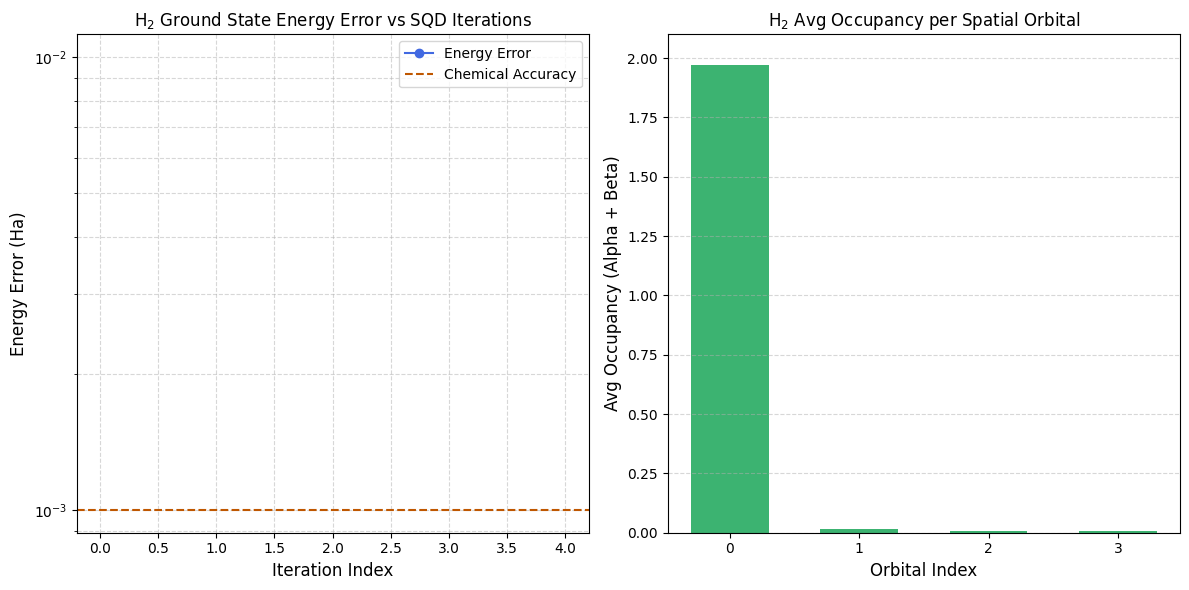

Target Exact Energy: -1.151614 Ha
Final SQD Energy:    -1.151614 Ha
Final Absolute Error: 0.000000 Ha


In [4]:
import matplotlib.pyplot as plt

# Chemical accuracy (+/- 1 milli-Hartree)
chem_accuracy = 0.001

# Data for energies plot
x1 = range(ITERATIONS)
min_e = [np.min(e) for e in energy_hist]
e_diff = [abs(e - exact_energy) for e in min_e]

# Data for avg spatial orbital occupancy (last iteration)
# Summing alpha and beta occupancy for total spatial occupancy
y2 = occupancy_hist[-1][0] + occupancy_hist[-1][1]
x2 = range(len(y2))

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1: Energy Convergence
axs[0].plot(x1, e_diff, label="Energy Error", marker="o", color='royalblue')
axs[0].axhline(y=chem_accuracy, color="#BF5700", linestyle="--", label="Chemical Accuracy")
axs[0].set_title("H$_2$ Ground State Energy Error vs SQD Iterations")
axs[0].set_xlabel("Iteration Index", fontsize=12)
axs[0].set_ylabel("Energy Error (Ha)", fontsize=12)
axs[0].set_yscale("log")
axs[0].grid(True, which='both', linestyle='--', alpha=0.5)
axs[0].legend()

# Plot 2: Orbital Occupancy
axs[1].bar(x2, y2, width=0.6, color='mediumseagreen')
axs[1].set_title("H$_2$ Avg Occupancy per Spatial Orbital")
axs[1].set_xlabel("Orbital Index", fontsize=12)
axs[1].set_ylabel("Avg Occupancy (Alpha + Beta)", fontsize=12)
axs[1].set_xticks(x2)
axs[1].set_ylim(0, 2.1) # Max occupancy is 2 electrons per orbital
axs[1].grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

print(f"Target Exact Energy: {exact_energy:.6f} Ha")
print(f"Final SQD Energy:    {min_e[-1]:.6f} Ha")
print(f"Final Absolute Error: {e_diff[-1]:.6f} Ha")

Starting robust LiH PES scan (20 points)...
------------------------------
Dist (A)   | Energy (Ha)    
------------------------------


0.50       | -7.050225
0.68       | -7.480018
0.87       | -7.698760
1.05       | -7.808152
1.24       | -7.859603
1.42       | -7.879670
1.61       | -7.882235
1.79       | -7.875115
1.97       | -7.863031
2.16       | -7.848960
2.34       | -7.834853
2.53       | -7.821999
2.71       | -7.811179
2.89       | -7.802687
3.08       | -7.796394
3.26       | -7.791915
3.45       | -7.788808
3.63       | -7.786683
3.82       | -7.785245
4.00       | -7.784278
------------------------------


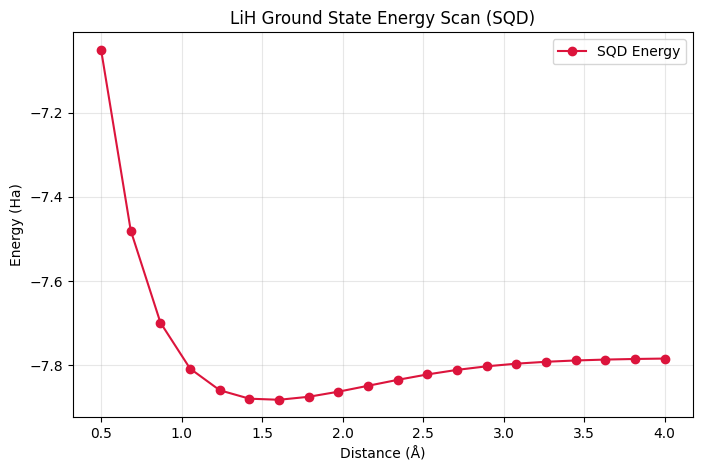

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from pyscf import gto, scf, ao2mo
from qiskit_addon_sqd.counts import generate_counts_uniform, counts_to_arrays
from qiskit_addon_sqd.configuration_recovery import recover_configurations
from qiskit_addon_sqd.subsampling import postselect_by_hamming_right_and_left, subsample
from qiskit_addon_sqd.fermion import solve_fermion

# =========================================
# 1. Helper Function: LiH Integrals
# =========================================
def get_lih_integrals(distance):
    mol = gto.Mole()
    mol.build(atom=f'Li 0 0 0; H 0 0 {distance}', basis='sto-3g', spin=0, charge=0, verbose=0)
    mf = scf.RHF(mol)
    mf.kernel()
    num_orb = mol.nao_nr()
    h1 = mf.mo_coeff.T @ mf.get_hcore() @ mf.mo_coeff
    eri = ao2mo.restore(1, ao2mo.kernel(mol, mf.mo_coeff), num_orb)
    return h1, eri, mol.energy_nuc(), num_orb, mol.nelec

# =========================================
# 2. Robust Core SQD Solver
# =========================================
def solve_sqd_lih_robust(distance, rng_seed=42):
    h1, eri, nuc_e, num_orb, (na, nb) = get_lih_integrals(distance)

    # --- IMPROVEMENT 1: Increase initial shots significantly ---
    NUM_SHOTS = 100000
    rng = np.random.default_rng(rng_seed)
    counts = generate_counts_uniform(NUM_SHOTS, num_orb * 2, rand_seed=rng)
    bs_full, probs_full = counts_to_arrays(counts)

    # SQD Options
    ITERATIONS = 5
    NUM_BATCHES = 1
    # --- IMPROVEMENT 2: Lower batch size slightly to ensure convergence ---
    SAMPLES_PER_BATCH = 150
    avg_occ = None
    best_E = np.inf

    for i in range(ITERATIONS):
        if avg_occ is None:
            bs_tmp, probs_tmp = bs_full, probs_full
        else:
            bs_tmp, probs_tmp = recover_configurations(
                bs_full, probs_full, avg_occ, na, nb, rand_seed=rng
            )

        # Post-select
        bs_ps, probs_ps = postselect_by_hamming_right_and_left(
            bs_tmp, probs_tmp, hamming_right=na, hamming_left=nb
        )

        # --- DIAGNOSTIC: Check if we have enough samples ---
        if bs_ps.shape[0] < SAMPLES_PER_BATCH:
            # print(f"  Debug: Iter {i} failed. Found {bs_ps.shape[0]} valid samples, needed {SAMPLES_PER_BATCH}")
            break

        # Subsample
        batches = subsample(bs_ps, probs_ps, SAMPLES_PER_BATCH, NUM_BATCHES, rand_seed=rng)

        if batches[0].shape[0] == 0: break

        # Diagonalize
        try:
            e_sci, _, new_occ, _ = solve_fermion(
                batches[0], h1, eri, open_shell=False, spin_sq=0, max_cycle=100
            )
            if (e_sci + nuc_e) < best_E:
                best_E = e_sci + nuc_e
                avg_occ = tuple(new_occ)
        except:
            continue

    return best_E if best_E != np.inf else np.nan

# =========================================
# 3. Run Scan
# =========================================
# Using fewer points for speed in testing, increase to 30 or 50 for final graph
distances = np.linspace(0.5, 4.0, 20)
sqd_energies = []

print(f"Starting robust LiH PES scan ({len(distances)} points)...")
print("-" * 30)
print(f"{'Dist (A)':<10} | {'Energy (Ha)':<15}")
print("-" * 30)

for i, d in enumerate(distances):
    try:
        en = solve_sqd_lih_robust(d, rng_seed=100 + i)
        sqd_energies.append(en)
        print(f"{d:<10.2f} | {en:.6f}")
    except Exception as e:
        print(f"{d:<10.2f} | Error: {e}")
        sqd_energies.append(np.nan)

print("-" * 30)

# Filter nans for plotting just in case some still fail
valid_indices = ~np.isnan(sqd_energies)
d_valid = distances[valid_indices]
e_valid = np.array(sqd_energies)[valid_indices]

plt.figure(figsize=(8, 5))
plt.plot(d_valid, e_valid, 'o-', color='crimson', label='SQD Energy')
plt.title('LiH Ground State Energy Scan (SQD)')
plt.xlabel('Distance (Å)')
plt.ylabel('Energy (Ha)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

Starting robust HF PES scan (20 points)...
------------------------------
Dist (A)   | Energy (Ha)    
------------------------------
0.50       | -97.713845
0.63       | -98.296303
0.76       | -98.516947
0.89       | -98.591651
1.03       | -98.602428
1.16       | -98.585979
1.29       | -98.560334
1.42       | -98.533908
1.55       | -98.510500
1.68       | -98.491775
1.82       | -98.478045
1.95       | -98.468673
2.08       | -98.462605
2.21       | -98.451039
2.34       | -98.451937
2.47       | -98.452449
2.61       | -98.452738
2.74       | -98.453753
2.87       | -98.452988
3.00       | -98.453036
------------------------------


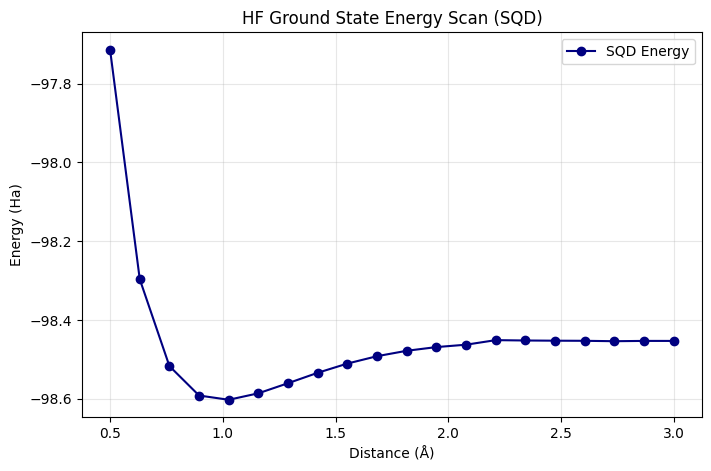

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from pyscf import gto, scf, ao2mo
from qiskit_addon_sqd.counts import generate_counts_uniform, counts_to_arrays
from qiskit_addon_sqd.configuration_recovery import recover_configurations
from qiskit_addon_sqd.subsampling import postselect_by_hamming_right_and_left, subsample
from qiskit_addon_sqd.fermion import solve_fermion

# =========================================
# 1. Helper Function: HF Integrals
# =========================================
def get_hf_integrals(distance):
    # Changed atom definition for Hydrogen Fluoride
    # H at origin, F moving along Z axis
    mol = gto.Mole()
    mol.build(atom=f'H 0 0 0; F 0 0 {distance}', basis='sto-3g', spin=0, charge=0, verbose=0)
    
    mf = scf.RHF(mol)
    mf.kernel()
    
    num_orb = mol.nao_nr()
    h1 = mf.mo_coeff.T @ mf.get_hcore() @ mf.mo_coeff
    eri = ao2mo.restore(1, ao2mo.kernel(mol, mf.mo_coeff), num_orb)
    
    return h1, eri, mol.energy_nuc(), num_orb, mol.nelec

# =========================================
# 2. Robust Core SQD Solver
# =========================================
def solve_sqd_hf_robust(distance, rng_seed=42):
    h1, eri, nuc_e, num_orb, (na, nb) = get_hf_integrals(distance)

    # HF is 10 electrons in 6 orbitals (12 spin-orbitals).
    # The filling fraction is high, so random sampling struggles to find the specific N=10 sector.
    # We increase shots and will inject the HF state below.
    NUM_SHOTS = 500000 
    rng = np.random.default_rng(rng_seed)
    
    # Generate uniform counts across 2*num_orb qubits
    counts = generate_counts_uniform(NUM_SHOTS, num_orb * 2, rand_seed=rng)
    bs_full, probs_full = counts_to_arrays(counts)

    # --- FIX: Inject Hartree-Fock State ---
    # We manually add the Hartree-Fock configuration (lowest energy orbitals filled)
    # to ensure the solver has at least one valid starting point.
    hf_config = np.zeros(num_orb * 2, dtype=np.int8)
    
    # Fill lowest 'na' alpha orbitals (indices 0 to na-1)
    hf_config[:na] = 1
    # Fill lowest 'nb' beta orbitals (indices num_orb to num_orb + nb - 1)
    hf_config[num_orb : num_orb + nb] = 1
    
    # Stack the HF config onto the random samples
    bs_full = np.vstack([bs_full, hf_config])
    # Give it a small non-zero probability weight so it's carried through
    probs_full = np.append(probs_full, 1.0 / NUM_SHOTS)
    # --------------------------------------

    # SQD Options
    ITERATIONS = 5
    NUM_BATCHES = 1
    SAMPLES_PER_BATCH = 150
    
    avg_occ = None
    best_E = np.inf

    for i in range(ITERATIONS):
        if avg_occ is None:
            bs_tmp, probs_tmp = bs_full, probs_full
        else:
            bs_tmp, probs_tmp = recover_configurations(
                bs_full, probs_full, avg_occ, na, nb, rand_seed=rng
            )

        # Post-select based on electron number (HF: 5 alpha, 5 beta)
        # Note: hamming_right corresponds to first half of bits, left to second half in Qiskit SQD usually
        bs_ps, probs_ps = postselect_by_hamming_right_and_left(
            bs_tmp, probs_tmp, hamming_right=na, hamming_left=nb
        )

        if bs_ps.shape[0] < SAMPLES_PER_BATCH:
            # If we still don't have enough, try to proceed with what we have if not empty
            if bs_ps.shape[0] == 0:
                break
            # Otherwise just continue with smaller batch

        # Subsample
        # If we have fewer samples than requested, take them all
        current_batch_size = min(SAMPLES_PER_BATCH, bs_ps.shape[0])
        batches = subsample(bs_ps, probs_ps, current_batch_size, NUM_BATCHES, rand_seed=rng)

        if batches[0].shape[0] == 0: break

        # Diagonalize
        try:
            e_sci, _, new_occ, _ = solve_fermion(
                batches[0], h1, eri, open_shell=False, spin_sq=0, max_cycle=100
            )
            if (e_sci + nuc_e) < best_E:
                best_E = e_sci + nuc_e
                avg_occ = tuple(new_occ)
        except:
            continue

    return best_E if best_E != np.inf else np.nan

# =========================================
# 3. Run Scan
# =========================================
# HF bond length is ~0.92 Angstrom, so we scan from 0.5 to 3.0
distances = np.linspace(0.5, 3.0, 20)
sqd_energies = []

print(f"Starting robust HF PES scan ({len(distances)} points)...")
print("-" * 30)
print(f"{'Dist (A)':<10} | {'Energy (Ha)':<15}")
print("-" * 30)

for i, d in enumerate(distances):
    try:
        en = solve_sqd_hf_robust(d, rng_seed=100 + i)
        sqd_energies.append(en)
        print(f"{d:<10.2f} | {en:.6f}")
    except Exception as e:
        print(f"{d:<10.2f} | Error: {e}")
        sqd_energies.append(np.nan)

print("-" * 30)

# Filter nans for plotting
valid_indices = ~np.isnan(sqd_energies)
d_valid = distances[valid_indices]
e_valid = np.array(sqd_energies)[valid_indices]

plt.figure(figsize=(8, 5))
plt.plot(d_valid, e_valid, 'o-', color='navy', label='SQD Energy')
plt.title('HF Ground State Energy Scan (SQD)')
plt.xlabel('Distance (Å)')
plt.ylabel('Energy (Ha)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

Starting robust OH- PES scan (20 points)...
------------------------------
Dist (A)   | Energy (Ha)    
------------------------------
0.50       | -73.130042
0.63       | -73.720775
0.76       | -73.961024
0.89       | -74.057661
1.03       | -74.090945
1.16       | -74.094339
1.29       | -74.083516
1.42       | -74.065984
1.55       | -74.045340
1.68       | -74.023613
1.82       | -74.002245
1.95       | -73.939817
2.08       | -73.933126
2.21       | -73.925912
2.34       | -73.918966
2.47       | -73.912736
2.61       | -73.907444
2.74       | -73.903169
2.87       | -73.899893
3.00       | -73.897522
------------------------------


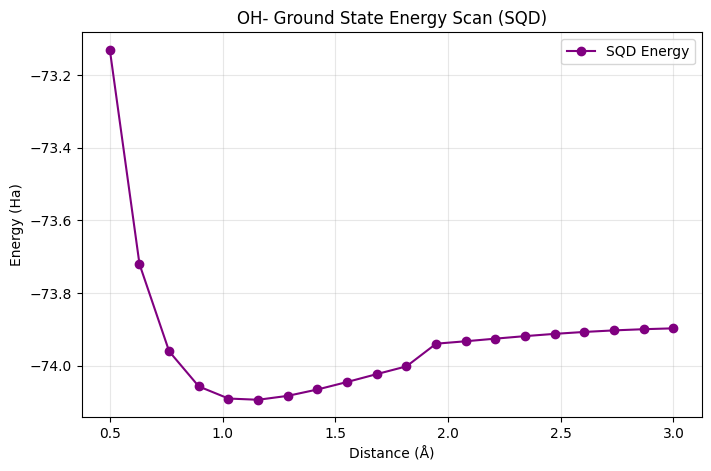

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from pyscf import gto, scf, ao2mo
from qiskit_addon_sqd.counts import generate_counts_uniform, counts_to_arrays
from qiskit_addon_sqd.configuration_recovery import recover_configurations
from qiskit_addon_sqd.subsampling import postselect_by_hamming_right_and_left, subsample
from qiskit_addon_sqd.fermion import solve_fermion

# =========================================
# 1. Helper Function: OH- Integrals
# =========================================
def get_oh_integrals(distance):
    # OH- is an anion with charge -1.
    # Total electrons = 8 (O) + 1 (H) + 1 (charge) = 10 electrons.
    mol = gto.Mole()
    mol.build(atom=f'O 0 0 0; H 0 0 {distance}', basis='sto-3g', spin=0, charge=-1, verbose=0)
    
    mf = scf.RHF(mol)
    mf.kernel()
    
    num_orb = mol.nao_nr()
    h1 = mf.mo_coeff.T @ mf.get_hcore() @ mf.mo_coeff
    eri = ao2mo.restore(1, ao2mo.kernel(mol, mf.mo_coeff), num_orb)
    
    return h1, eri, mol.energy_nuc(), num_orb, mol.nelec

# =========================================
# 2. Robust Core SQD Solver
# =========================================
def solve_sqd_oh_robust(distance, rng_seed=42):
    h1, eri, nuc_e, num_orb, (na, nb) = get_oh_integrals(distance)

    # OH- has 10 electrons, same as HF. 
    # High filling fraction requires high shots + HF injection.
    NUM_SHOTS = 500000 
    rng = np.random.default_rng(rng_seed)
    
    # Generate uniform counts across 2*num_orb qubits
    counts = generate_counts_uniform(NUM_SHOTS, num_orb * 2, rand_seed=rng)
    bs_full, probs_full = counts_to_arrays(counts)

    # --- INJECT HARTREE-FOCK STATE ---
    # Manually add the lowest energy configuration to ensure solver stability.
    hf_config = np.zeros(num_orb * 2, dtype=np.int8)
    
    # Fill lowest 'na' alpha orbitals and lowest 'nb' beta orbitals
    hf_config[:na] = 1
    hf_config[num_orb : num_orb + nb] = 1
    
    bs_full = np.vstack([bs_full, hf_config])
    probs_full = np.append(probs_full, 1.0 / NUM_SHOTS)
    # ---------------------------------

    # SQD Options
    ITERATIONS = 5
    NUM_BATCHES = 1
    SAMPLES_PER_BATCH = 150
    
    avg_occ = None
    best_E = np.inf

    for i in range(ITERATIONS):
        if avg_occ is None:
            bs_tmp, probs_tmp = bs_full, probs_full
        else:
            bs_tmp, probs_tmp = recover_configurations(
                bs_full, probs_full, avg_occ, na, nb, rand_seed=rng
            )

        # Post-select based on electron number (OH-: 5 alpha, 5 beta)
        bs_ps, probs_ps = postselect_by_hamming_right_and_left(
            bs_tmp, probs_tmp, hamming_right=na, hamming_left=nb
        )

        if bs_ps.shape[0] < SAMPLES_PER_BATCH:
            if bs_ps.shape[0] == 0:
                break
            # Continue with whatever samples we have if non-zero

        current_batch_size = min(SAMPLES_PER_BATCH, bs_ps.shape[0])
        batches = subsample(bs_ps, probs_ps, current_batch_size, NUM_BATCHES, rand_seed=rng)

        if batches[0].shape[0] == 0: break

        # Diagonalize
        try:
            e_sci, _, new_occ, _ = solve_fermion(
                batches[0], h1, eri, open_shell=False, spin_sq=0, max_cycle=100
            )
            if (e_sci + nuc_e) < best_E:
                best_E = e_sci + nuc_e
                avg_occ = tuple(new_occ)
        except:
            continue

    return best_E if best_E != np.inf else np.nan

# =========================================
# 3. Run Scan
# =========================================
# OH bond length is approx 0.96 A. Scanning 0.5 to 3.0 A.
distances = np.linspace(0.5, 3.0, 20)
sqd_energies = []

print(f"Starting robust OH- PES scan ({len(distances)} points)...")
print("-" * 30)
print(f"{'Dist (A)':<10} | {'Energy (Ha)':<15}")
print("-" * 30)

for i, d in enumerate(distances):
    try:
        en = solve_sqd_oh_robust(d, rng_seed=100 + i)
        sqd_energies.append(en)
        print(f"{d:<10.2f} | {en:.6f}")
    except Exception as e:
        print(f"{d:<10.2f} | Error: {e}")
        sqd_energies.append(np.nan)

print("-" * 30)

# Filter nans for plotting
valid_indices = ~np.isnan(sqd_energies)
d_valid = distances[valid_indices]
e_valid = np.array(sqd_energies)[valid_indices]

plt.figure(figsize=(8, 5))
plt.plot(d_valid, e_valid, 'o-', color='purple', label='SQD Energy')
plt.title('OH- Ground State Energy Scan (SQD)')
plt.xlabel('Distance (Å)')
plt.ylabel('Energy (Ha)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

Starting robust H2O PES scan (20 points)...
------------------------------
Dist (A)   | Energy (Ha)    
------------------------------


0.50       | -73.137644
0.63       | -74.342845
0.76       | -74.815246
0.89       | -74.984373
1.03       | -75.020813
1.16       | -74.998309
1.29       | -74.952794
1.42       | -74.902285
1.55       | -74.855515
1.68       | -74.816722
1.82       | -74.787590
1.95       | -74.767730
2.08       | -74.755260
2.21       | -74.747832
2.34       | -74.743496
2.47       | -74.737140
2.61       | -74.738125
2.74       | -74.738515
2.87       | -74.737620
3.00       | -74.737338
------------------------------


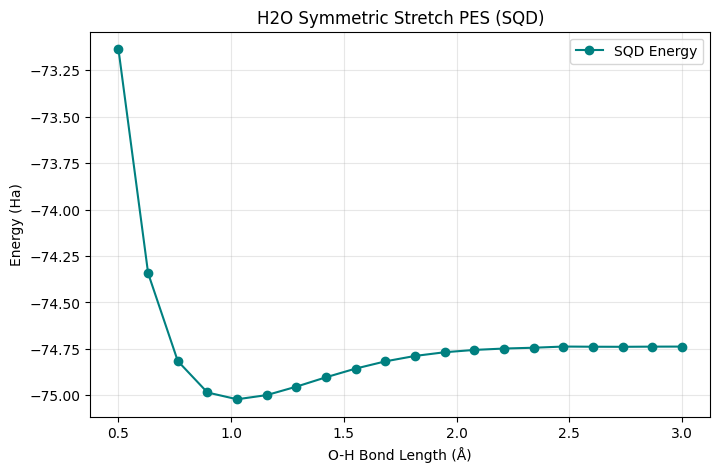

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from pyscf import gto, scf, ao2mo
from qiskit_addon_sqd.counts import generate_counts_uniform, counts_to_arrays
from qiskit_addon_sqd.configuration_recovery import recover_configurations
from qiskit_addon_sqd.subsampling import postselect_by_hamming_right_and_left, subsample
from qiskit_addon_sqd.fermion import solve_fermion

# =========================================
# 1. Helper Function: H2O Integrals
# =========================================
def get_h2o_integrals(distance):
    # H2O: Neutral molecule.
    # Total electrons = 8 (O) + 1 (H) + 1 (H) = 10 electrons.
    # Geometry: Symmetric stretch with fixed angle 104.5 degrees.
    
    # Calculate coordinates
    angle_rad = (104.5 * np.pi / 180) / 2
    x = distance * np.sin(angle_rad)
    y = distance * np.cos(angle_rad)
    
    atom_str = f'O 0.0 0.0 0.0; H {x} {y} 0.0; H -{x} {y} 0.0'
    
    mol = gto.Mole()
    mol.build(atom=atom_str, basis='sto-3g', spin=0, charge=0, verbose=0)
    
    mf = scf.RHF(mol)
    mf.kernel()
    
    num_orb = mol.nao_nr()
    h1 = mf.mo_coeff.T @ mf.get_hcore() @ mf.mo_coeff
    eri = ao2mo.restore(1, ao2mo.kernel(mol, mf.mo_coeff), num_orb)
    
    return h1, eri, mol.energy_nuc(), num_orb, mol.nelec

# =========================================
# 2. Robust Core SQD Solver
# =========================================
def solve_sqd_h2o_robust(distance, rng_seed=42):
    h1, eri, nuc_e, num_orb, (na, nb) = get_h2o_integrals(distance)

    # H2O (STO-3G) has 7 spatial orbitals (14 spin-orbitals) and 10 electrons.
    # This is a dense system, so we keep shots high and use HF injection.
    NUM_SHOTS = 500000 
    rng = np.random.default_rng(rng_seed)
    
    # Generate uniform counts across 2*num_orb qubits
    counts = generate_counts_uniform(NUM_SHOTS, num_orb * 2, rand_seed=rng)
    bs_full, probs_full = counts_to_arrays(counts)

    # --- INJECT HARTREE-FOCK STATE ---
    # Ensure they are numpy arrays to prevent dimension mismatch errors
    bs_full = np.array(bs_full)
    probs_full = np.array(probs_full)

    # Manually add the lowest energy configuration to ensure solver stability.
    hf_config = np.zeros(num_orb * 2, dtype=bs_full.dtype)
    
    # Fill lowest 'na' alpha orbitals and lowest 'nb' beta orbitals
    hf_config[:na] = 1
    hf_config[num_orb : num_orb + nb] = 1
    
    bs_full = np.vstack([bs_full, hf_config])
    probs_full = np.append(probs_full, 1.0 / NUM_SHOTS)
    
    # CRITICAL: Renormalize probabilities to sum to 1.0
    # This fixes "a and p must have same size" errors in random.choice
    if np.sum(probs_full) > 0:
        probs_full = probs_full / np.sum(probs_full)
    # ---------------------------------

    # SQD Options
    ITERATIONS = 5
    NUM_BATCHES = 1
    SAMPLES_PER_BATCH = 150
    
    avg_occ = None
    best_E = np.inf

    for i in range(ITERATIONS):
        if avg_occ is None:
            bs_tmp, probs_tmp = bs_full, probs_full
        else:
            bs_tmp, probs_tmp = recover_configurations(
                bs_full, probs_full, avg_occ, na, nb, rand_seed=rng
            )

        # Post-select based on electron number (H2O: 5 alpha, 5 beta)
        bs_ps, probs_ps = postselect_by_hamming_right_and_left(
            bs_tmp, probs_tmp, hamming_right=na, hamming_left=nb
        )

        if bs_ps.shape[0] < SAMPLES_PER_BATCH:
            if bs_ps.shape[0] == 0:
                break
            # Continue with whatever samples we have if non-zero

        current_batch_size = min(SAMPLES_PER_BATCH, bs_ps.shape[0])
        batches = subsample(bs_ps, probs_ps, current_batch_size, NUM_BATCHES, rand_seed=rng)

        if batches[0].shape[0] == 0: break

        # Diagonalize
        try:
            e_sci, _, new_occ, _ = solve_fermion(
                batches[0], h1, eri, open_shell=False, spin_sq=0, max_cycle=100
            )
            if (e_sci + nuc_e) < best_E:
                best_E = e_sci + nuc_e
                avg_occ = tuple(new_occ)
        except:
            continue

    return best_E if best_E != np.inf else np.nan

# =========================================
# 3. Run Scan
# =========================================
# Symmetric stretch of O-H bonds (fixed angle).
distances = np.linspace(0.5, 3.0, 20)
sqd_energies = []

print(f"Starting robust H2O PES scan ({len(distances)} points)...")
print("-" * 30)
print(f"{'Dist (A)':<10} | {'Energy (Ha)':<15}")
print("-" * 30)

for i, d in enumerate(distances):
    try:
        en = solve_sqd_h2o_robust(d, rng_seed=100 + i)
        sqd_energies.append(en)
        print(f"{d:<10.2f} | {en:.6f}")
    except Exception as e:
        print(f"{d:<10.2f} | Error: {e}")
        sqd_energies.append(np.nan)

print("-" * 30)

# Filter nans for plotting
valid_indices = ~np.isnan(sqd_energies)
d_valid = distances[valid_indices]
e_valid = np.array(sqd_energies)[valid_indices]

plt.figure(figsize=(8, 5))
plt.plot(d_valid, e_valid, 'o-', color='teal', label='SQD Energy')
plt.title('H2O Symmetric Stretch PES (SQD)')
plt.xlabel('O-H Bond Length (Å)')
plt.ylabel('Energy (Ha)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

Starting robust BH3 PES scan (20 points)...
------------------------------
Dist (A)   | Energy (Ha)    
------------------------------
0.60       | -24.387870
0.73       | -25.325249
0.85       | -25.799317
0.98       | -26.024179
1.11       | -26.110726
1.23       | -26.118800
1.36       | -26.082264
1.48       | -26.021636
1.61       | -25.950177
1.74       | -25.876880
1.86       | -25.807992
1.99       | -25.747862
2.12       | -25.699216
2.24       | -25.662958
2.37       | -25.637872
2.49       | -25.621281
2.62       | -25.610386
2.75       | -25.603238
2.87       | -25.598448
3.00       | -25.588585
------------------------------


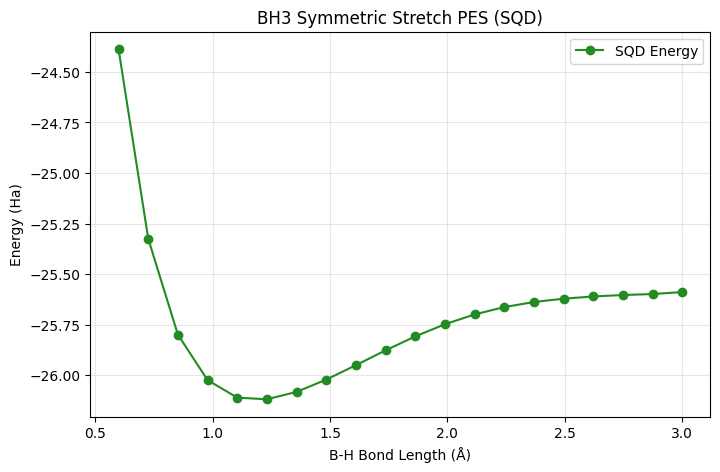

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from pyscf import gto, scf, ao2mo
from qiskit_addon_sqd.counts import generate_counts_uniform, counts_to_arrays
from qiskit_addon_sqd.configuration_recovery import recover_configurations
from qiskit_addon_sqd.subsampling import postselect_by_hamming_right_and_left, subsample
from qiskit_addon_sqd.fermion import solve_fermion

# =========================================
# 1. Helper Function: BH3 Integrals
# =========================================
def get_bh3_integrals(distance):
    # BH3: Trigonal Planar geometry (D3h symmetry).
    # Total electrons = 5 (B) + 3*1 (H) = 8 electrons.
    # We place Boron at the origin and Hydrogens in the XY plane.
    
    # 120 degrees in radians for trigonal planar spacing
    theta = 2 * np.pi / 3
    
    # Coordinates for Hydrogens
    # H1: On x-axis
    h1_x, h1_y = distance, 0.0
    # H2: Rotated 120 degrees
    h2_x, h2_y = distance * np.cos(theta), distance * np.sin(theta)
    # H3: Rotated 240 degrees (or -120)
    h3_x, h3_y = distance * np.cos(2*theta), distance * np.sin(2*theta)
    
    atom_str = f'B 0 0 0; H {h1_x} {h1_y} 0; H {h2_x} {h2_y} 0; H {h3_x} {h3_y} 0'
    
    mol = gto.Mole()
    mol.build(atom=atom_str, basis='sto-3g', spin=0, charge=0, verbose=0)
    
    mf = scf.RHF(mol)
    mf.kernel()
    
    num_orb = mol.nao_nr()
    h1 = mf.mo_coeff.T @ mf.get_hcore() @ mf.mo_coeff
    eri = ao2mo.restore(1, ao2mo.kernel(mol, mf.mo_coeff), num_orb)
    
    return h1, eri, mol.energy_nuc(), num_orb, mol.nelec

# =========================================
# 2. Robust Core SQD Solver
# =========================================
def solve_sqd_bh3_robust(distance, rng_seed=42):
    h1, eri, nuc_e, num_orb, (na, nb) = get_bh3_integrals(distance)

    # BH3 (STO-3G) has 8 spatial orbitals (16 spin-orbitals) and 8 electrons.
    # Similar complexity to H2O, so we keep high shots and HF injection.
    NUM_SHOTS = 500000 
    rng = np.random.default_rng(rng_seed)
    
    # Generate uniform counts across 2*num_orb qubits
    counts = generate_counts_uniform(NUM_SHOTS, num_orb * 2, rand_seed=rng)
    bs_full, probs_full = counts_to_arrays(counts)

    # --- INJECT HARTREE-FOCK STATE ---
    # Ensure they are numpy arrays to prevent dimension mismatch errors
    bs_full = np.array(bs_full)
    probs_full = np.array(probs_full)

    # Manually add the lowest energy configuration to ensure solver stability.
    hf_config = np.zeros(num_orb * 2, dtype=bs_full.dtype)
    
    # Fill lowest 'na' alpha orbitals and lowest 'nb' beta orbitals
    hf_config[:na] = 1
    hf_config[num_orb : num_orb + nb] = 1
    
    bs_full = np.vstack([bs_full, hf_config])
    probs_full = np.append(probs_full, 1.0 / NUM_SHOTS)
    
    # CRITICAL: Renormalize probabilities to sum to 1.0
    if np.sum(probs_full) > 0:
        probs_full = probs_full / np.sum(probs_full)
    # ---------------------------------

    # SQD Options
    ITERATIONS = 5
    NUM_BATCHES = 1
    SAMPLES_PER_BATCH = 150
    
    avg_occ = None
    best_E = np.inf

    for i in range(ITERATIONS):
        if avg_occ is None:
            bs_tmp, probs_tmp = bs_full, probs_full
        else:
            bs_tmp, probs_tmp = recover_configurations(
                bs_full, probs_full, avg_occ, na, nb, rand_seed=rng
            )

        # Post-select based on electron number (BH3: 4 alpha, 4 beta)
        bs_ps, probs_ps = postselect_by_hamming_right_and_left(
            bs_tmp, probs_tmp, hamming_right=na, hamming_left=nb
        )

        if bs_ps.shape[0] < SAMPLES_PER_BATCH:
            if bs_ps.shape[0] == 0:
                break
            # Continue with whatever samples we have if non-zero

        current_batch_size = min(SAMPLES_PER_BATCH, bs_ps.shape[0])
        batches = subsample(bs_ps, probs_ps, current_batch_size, NUM_BATCHES, rand_seed=rng)

        if batches[0].shape[0] == 0: break

        # Diagonalize
        try:
            e_sci, _, new_occ, _ = solve_fermion(
                batches[0], h1, eri, open_shell=False, spin_sq=0, max_cycle=100
            )
            if (e_sci + nuc_e) < best_E:
                best_E = e_sci + nuc_e
                avg_occ = tuple(new_occ)
        except:
            continue

    return best_E if best_E != np.inf else np.nan

# =========================================
# 3. Run Scan
# =========================================
# Symmetric stretch of B-H bonds (Trigonal Planar).
distances = np.linspace(0.6, 3.0, 20)
sqd_energies = []

print(f"Starting robust BH3 PES scan ({len(distances)} points)...")
print("-" * 30)
print(f"{'Dist (A)':<10} | {'Energy (Ha)':<15}")
print("-" * 30)

for i, d in enumerate(distances):
    try:
        en = solve_sqd_bh3_robust(d, rng_seed=100 + i)
        sqd_energies.append(en)
        print(f"{d:<10.2f} | {en:.6f}")
    except Exception as e:
        print(f"{d:<10.2f} | Error: {e}")
        sqd_energies.append(np.nan)

print("-" * 30)

# Filter nans for plotting
valid_indices = ~np.isnan(sqd_energies)
d_valid = distances[valid_indices]
e_valid = np.array(sqd_energies)[valid_indices]

plt.figure(figsize=(8, 5))
plt.plot(d_valid, e_valid, 'o-', color='forestgreen', label='SQD Energy')
plt.title('BH3 Symmetric Stretch PES (SQD)')
plt.xlabel('B-H Bond Length (Å)')
plt.ylabel('Energy (Ha)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

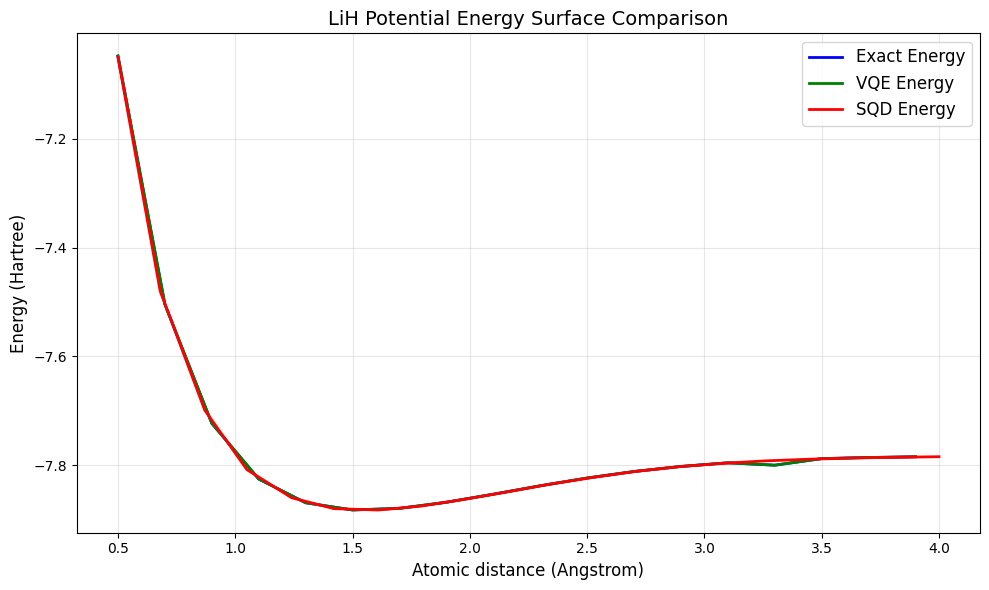

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# =========================================
# 1. Hardcoded Data
# =========================================

# --- SQD Data (20 points, 0.5 to 4.0 A) ---
sqd_dist = [
    0.50, 0.68, 0.87, 1.05, 1.24, 1.42, 1.61, 1.79, 1.97, 2.16,
    2.34, 2.53, 2.71, 2.89, 3.08, 3.26, 3.45, 3.63, 3.82, 4.00
]
sqd_energy = [
    -7.050225, -7.480018, -7.698760, -7.808152, -7.859603,
    -7.879670, -7.882235, -7.875115, -7.863031, -7.848960,
    -7.834853, -7.821999, -7.811179, -7.802687, -7.796394,
    -7.791915, -7.788808, -7.786683, -7.785245, -7.784278
]

# --- VQE & Exact Data (18 points, 0.5 to 3.9 A) ---
vqe_dist = [
    0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1,
    2.3, 2.5, 2.7, 2.9, 3.1, 3.3, 3.5, 3.7, 3.9
]
vqe_energy = [
    -7.04791, -7.50400, -7.72283, -7.82520, -7.86890, -7.88214,
    -7.87920, -7.86799, -7.85320, -7.83772, -7.82343, -7.81142,
    -7.80215, -7.79545, -7.79984, -7.78776, -7.78573, -7.78441
]
exact_energy = [
    -7.04790898, -7.50399989, -7.72283459, -7.82520753, -7.86890408,
    -7.88213996, -7.87919789, -7.86798879, -7.85319625, -7.83772407,
    -7.82342699, -7.81142660, -7.80214665, -7.79545382, -7.79984572,
    -7.78776127, -7.78572986, -7.78440584
]

# =========================================
# 2. Plotting
# =========================================
plt.figure(figsize=(10, 6))

# Plot Exact Energy as a solid blue line
plt.plot(vqe_dist, exact_energy, color='blue', linestyle='-', linewidth=2, label="Exact Energy")

# Plot VQE Energy as a solid green line
plt.plot(vqe_dist, vqe_energy, color='green', linestyle='-', linewidth=2, label="VQE Energy")

# Plot SQD Energy as a solid red line
plt.plot(sqd_dist, sqd_energy, color='red', linestyle='-', linewidth=2, label="SQD Energy")

# Labels and formatting
plt.xlabel("Atomic distance (Angstrom)", fontsize=12)
plt.ylabel("Energy (Hartree)", fontsize=12)
plt.title("LiH Potential Energy Surface Comparison", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()

Starting N2 PES scan (2 points)... this may take a minute.
------------------------------
Dist (A)   | Energy (Ha)    
------------------------------
1.80       | -107.483457
2.00       | -107.455156
------------------------------


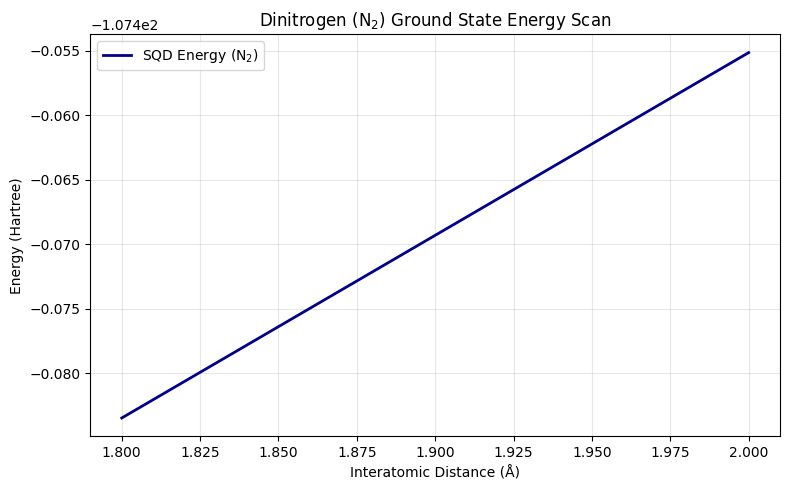

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyscf import gto, scf, ao2mo
from qiskit_addon_sqd.counts import generate_counts_uniform, counts_to_arrays
from qiskit_addon_sqd.configuration_recovery import recover_configurations
from qiskit_addon_sqd.subsampling import postselect_by_hamming_right_and_left, subsample
from qiskit_addon_sqd.fermion import solve_fermion

# =========================================
# 1. Helper Function: N2 Integrals
# =========================================
def get_n2_integrals(distance):
    """
    Builds N2 molecule at a specific distance and returns Hamiltonian integrals.
    Uses STO-3G basis (10 spatial orbitals, 20 qubits, 14 electrons).
    """
    mol = gto.Mole()
    # N2 molecule centered at origin along Z-axis
    mol.build(
        atom=f'N 0 0 {-distance/2}; N 0 0 {distance/2}',
        basis='sto-3g',
        spin=0,
        charge=0,
        verbose=0
    )

    # Classical Hartree-Fock calculation
    mf = scf.RHF(mol)
    mf.kernel()

    # Extract problem size and integrals for SQD
    num_orb = mol.nao_nr()
    n_alpha, n_beta = mol.nelec
    nuc_e = mol.energy_nuc()

    # 1-body integrals (Core Hamiltonian)
    h1 = mf.mo_coeff.T @ mf.get_hcore() @ mf.mo_coeff
    # 2-body integrals (Electron Repulsion)
    eri = ao2mo.kernel(mol, mf.mo_coeff)
    eri = ao2mo.restore(1, eri, num_orb)

    return h1, eri, nuc_e, num_orb, n_alpha, n_beta

# =========================================
# 2. Robust SQD Solver for Complex Molecules (N2)
# =========================================
def solve_sqd_n2(distance, rng_seed=42):
    h1, eri, nuc_e, num_orb, na, nb = get_n2_integrals(distance)

    # --- N2 SPECIFIC SETTINGS ---
    # N2 has a much larger Hilbert space (2^20 approx 1 Million states).
    # We need MANY more shots to find enough valid (14-electron) states.
    NUM_SHOTS = 500000
    SAMPLES_PER_BATCH = 1000  # Need larger subspace to capture N2 physics
    ITERATIONS = 5
    NUM_BATCHES = 1

    rng = np.random.default_rng(rng_seed)
    # Generate initial random noise
    counts = generate_counts_uniform(NUM_SHOTS, num_orb * 2, rand_seed=rng)
    bs_full, probs_full = counts_to_arrays(counts)

    avg_occ = None
    best_E = np.inf

    # --- Main SQD Loop ---
    for i in range(ITERATIONS):
        if avg_occ is None:
            bs_tmp, probs_tmp = bs_full, probs_full
        else:
            bs_tmp, probs_tmp = recover_configurations(
                bs_full, probs_full, avg_occ, na, nb, rand_seed=rng
            )

        # Post-select (Filter for 7 alpha, 7 beta electrons)
        bs_ps, probs_ps = postselect_by_hamming_right_and_left(
            bs_tmp, probs_tmp, hamming_right=na, hamming_left=nb
        )

        # Diagnostic print for tough N2 problem
        # print(f"  Iter {i}: Found {bs_ps.shape[0]} valid samples out of {NUM_SHOTS}")

        if bs_ps.shape[0] < SAMPLES_PER_BATCH:
             # print("  Not enough valid samples found. Skipping iteration.")
             break

        # Subsample
        batches = subsample(bs_ps, probs_ps, SAMPLES_PER_BATCH, NUM_BATCHES, rand_seed=rng)
        if batches[0].shape[0] == 0: break

        # Diagonalize
        try:
            e_sci, _, new_occ, _ = solve_fermion(
                batches[0], h1, eri, open_shell=False, spin_sq=0, max_cycle=200
            )
            current_E = e_sci + nuc_e
            if current_E < best_E:
                best_E = current_E
                avg_occ = tuple(new_occ)
        except:
            continue

    return best_E if best_E != np.inf else np.nan

# =========================================
# 3. Run N2 Scan and Plot
# =========================================

# Scan around equilibrium (~1.1 Angstroms).
# Fewer points (10) used here to keep run-time reasonable for a demo.
distances = np.linspace(1.8, 2.0, 2)
sqd_energies = []

print(f"Starting N2 PES scan ({len(distances)} points)... this may take a minute.")
print("-" * 30)
print(f"{'Dist (A)':<10} | {'Energy (Ha)':<15}")
print("-" * 30)

for i, d in enumerate(distances):
    try:
        # Using different seeds to avoid correlated noise artifacts between points
        en = solve_sqd_n2(d, rng_seed=500 + i*10)
        sqd_energies.append(en)
        print(f"{d:<10.2f} | {en:.6f}")
    except Exception as e:
        print(f"{d:<10.2f} | Error/Nan")
        sqd_energies.append(np.nan)

print("-" * 30)

# Filter NaNs for pure plotting
valid_mask = np.isfinite(sqd_energies)
d_valid = distances[valid_mask]
e_valid = np.array(sqd_energies)[valid_mask]

if len(d_valid) > 0:
    plt.figure(figsize=(8, 5))
    # Using only lines as requested previously
    plt.plot(d_valid, e_valid, linestyle='-', linewidth=2, color='darkblue', label='SQD Energy (N$_2$)')
    plt.title('Dinitrogen (N$_2$) Ground State Energy Scan')
    plt.xlabel('Interatomic Distance (Å)')
    plt.ylabel('Energy (Hartree)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Failed to converge on enough points to plot.")

In [ ]:
Starting N2 PES scan (10 points)... this may take a minute.
------------------------------
Dist (A)   | Energy (Ha)    
------------------------------
0.80       | -106.766308
0.93       | -107.401348
1.07       | -107.630944
1.20       | -107.677340
1.33       | -107.648540
1.47       | -107.595543
1.60       | -107.542086
1.73       | -107.499376

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pyscf import gto, scf, ao2mo, fci
from qiskit_addon_sqd.counts import generate_counts_uniform, counts_to_arrays
from qiskit_addon_sqd.configuration_recovery import recover_configurations
from qiskit_addon_sqd.subsampling import postselect_by_hamming_right_and_left, subsample
from qiskit_addon_sqd.fermion import solve_fermion

# =========================================
# 1. Helper Function: N2 Integrals
# =========================================
def get_n2_integrals(distance):
    """
    Builds N2 molecule at a specific distance and returns Hamiltonian integrals.
    Uses STO-3G basis (10 spatial orbitals, 20 qubits, 14 electrons).
    """
    mol = gto.Mole()
    # N2 molecule centered at origin along Z-axis
    mol.build(
        atom=f'N 0 0 {-distance/2}; N 0 0 {distance/2}',
        basis='sto-3g',
        spin=0,
        charge=0,
        verbose=0
    )

    # Classical Hartree-Fock calculation
    mf = scf.RHF(mol)
    mf.kernel()

    # Extract problem size and integrals for SQD
    num_orb = mol.nao_nr()
    n_alpha, n_beta = mol.nelec
    nuc_e = mol.energy_nuc()

    # 1-body integrals (Core Hamiltonian)
    h1 = mf.mo_coeff.T @ mf.get_hcore() @ mf.mo_coeff
    # 2-body integrals (Electron Repulsion)
    eri = ao2mo.kernel(mol, mf.mo_coeff)
    eri = ao2mo.restore(1, eri, num_orb)

    # Return the Hartree-Fock object as well for FCI calculation
    return h1, eri, nuc_e, num_orb, n_alpha, n_beta, mf

# =========================================
# 2. Robust SQD Solver for Complex Molecules (N2)
# =========================================
def solve_sqd_n2(distance, rng_seed=42):
    h1, eri, nuc_e, num_orb, na, nb, _ = get_n2_integrals(distance)

    # --- N2 SPECIFIC SETTINGS ---
    NUM_SHOTS = 500000
    SAMPLES_PER_BATCH = 1000
    ITERATIONS = 5
    NUM_BATCHES = 1

    rng = np.random.default_rng(rng_seed)
    # Generate initial random noise
    counts = generate_counts_uniform(NUM_SHOTS, num_orb * 2, rand_seed=rng)
    bs_full, probs_full = counts_to_arrays(counts)

    avg_occ = None
    best_E = np.inf

    print(f"Starting SQD for N2 at {distance} Å...")
    print(f"  System: {num_orb} orbitals, {na+nb} electrons, {num_orb*2} qubits.")
    print(f"  Simulating {NUM_SHOTS} random shots...")

    # --- Main SQD Loop ---
    for i in range(ITERATIONS):
        if avg_occ is None:
            bs_tmp, probs_tmp = bs_full, probs_full
        else:
            bs_tmp, probs_tmp = recover_configurations(
                bs_full, probs_full, avg_occ, na, nb, rand_seed=rng
            )

        # Post-select (Filter for 7 alpha, 7 beta electrons)
        bs_ps, probs_ps = postselect_by_hamming_right_and_left(
            bs_tmp, probs_tmp, hamming_right=na, hamming_left=nb
        )
        
        print(f"  Iter {i+1}/{ITERATIONS}: Found {bs_ps.shape[0]} valid samples.")

        if bs_ps.shape[0] < SAMPLES_PER_BATCH:
             print("  Not enough valid samples found. Stopping loop.")
             break

        # Subsample
        batches = subsample(bs_ps, probs_ps, SAMPLES_PER_BATCH, NUM_BATCHES, rand_seed=rng)
        if batches[0].shape[0] == 0: 
            print("  Subsampling created an empty batch. Stopping.")
            break

        # Diagonalize
        try:
            e_sci, _, new_occ, _ = solve_fermion(
                batches[0], h1, eri, open_shell=False, spin_sq=0, max_cycle=200
            )
            current_E = e_sci + nuc_e
            if current_E < best_E:
                best_E = current_E
                avg_occ = tuple(new_occ)
            print(f"    Iter {i+1} Energy: {current_E:.6f} Ha")

        except Exception as e:
            print(f"    Iter {i+1} failed diagonalization: {e}")
            continue

    return best_E if best_E != np.inf else np.nan

# =========================================
# 3. Run Single-Point Calculation
# =========================================

# The bond distance for N2 equilibrium
distance = 1.098

print("--- Calculating Exact Energy (FCI) ---")
# Get integrals and mf object
h1, eri, nuc_e, num_orb, na, nb, mf = get_n2_integrals(distance)

# Run FCI (the exact classical solver)
cisolver = fci.FCI(mf)
exact_energy, _ = cisolver.kernel()
print(f"Exact FCI Energy: {exact_energy:.8f} Ha")
print("-" * 40)


print("--- Calculating SQD Energy ---")
# Using a fixed seed for reproducibility
sqd_energy = solve_sqd_n2(distance, rng_seed=500)
print("-" * 40)


print("\n--- Results ---")
print(f"Bond Distance: {distance} Å")
print(f"Exact FCI Energy: {exact_energy:.8f} Ha")
print(f"SQD Energy:       {sqd_energy:.8f} Ha")
print(f"Absolute Error:   {abs(sqd_energy - exact_energy):.8f} Ha")

--- Calculating Exact Energy (FCI) ---
Exact FCI Energy: -107.65299988 Ha
----------------------------------------
--- Calculating SQD Energy ---
Starting SQD for N2 at 1.098 Å...
  System: 10 orbitals, 14 electrons, 20 qubits.
  Simulating 500000 random shots...
  Iter 1/5: Found 5631 valid samples.
    Iter 1 Energy: -107.653000 Ha
  Iter 2/5: Found 14335 valid samples.
    Iter 2 Energy: -107.653000 Ha
  Iter 3/5: Found 14343 valid samples.
    Iter 3 Energy: -107.653000 Ha
  Iter 4/5: Found 14346 valid samples.
    Iter 4 Energy: -107.653000 Ha
  Iter 5/5: Found 14341 valid samples.
    Iter 5 Energy: -107.653000 Ha
----------------------------------------

--- Results ---
Bond Distance: 1.098 Å
Exact FCI Energy: -107.65299988 Ha
SQD Energy:       -107.65299988 Ha
Absolute Error:   0.00000000 Ha


In [1]:
from pyscf import ao2mo, tools
 
# Specify molecule properties
num_orbitals = 16
num_alpha = num_beta = 5
open_shell = False
spin_sq = 0
 
# Read in molecule from disk
molecule_scf = tools.fcidump.to_scf("n2_fci.txt")
 
# Core Hamiltonian representing the single-electron integrals
core_hamiltonian = molecule_scf.get_hcore()
 
# Electron repulsion integrals representing the two-electron integrals
electron_repulsion_integrals = ao2mo.restore(
    1, molecule_scf._eri, num_orbitals
)
 
# Nuclear repulsion energy of the molecule
nuclear_repulsion_energy = molecule_scf.mol.energy_nuc()

Parsing n2_fci.txt


FileNotFoundError: [Errno 2] No such file or directory: 'n2_fci.txt'

In [2]:
from qiskit_ibm_runtime import QiskitRuntimeService

# Save your account to disk (only need to run this once)
# Replace 'YOUR_API_TOKEN' with your actual token
QiskitRuntimeService.save_account(
    channel="ibm_quantum_platform", 
    token="cgkE9jNHSGB3_k2S2fO9jvcw344dhf_J0CrY6EcMbZ6w", 
    overwrite=True
)

# Load the service
service = QiskitRuntimeService()

qiskit_runtime_service.__init__:WARNING:2025-12-03 12:49:54,303: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: SQD. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().


In [3]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()

# This should print the name of the real quantum computer you are connected to
# e.g., 'ibm_brisbane', 'ibm_kyoto', etc.
backend = service.least_busy(operational=True, simulator=False)
print(f"Success! You are connected to: {backend.name}")
print(f"Number of qubits: {backend.num_qubits}")

qiskit_runtime_service.__init__:WARNING:2025-12-03 12:56:22,199: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: SQD. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2025-12-03 12:56:24,081: Loading instance: SQD, plan: open
qiskit_runtime_service.backends:WARNING:2025-12-03 12:56:28,319: Using instance: SQD, plan: open


Success! You are connected to: ibm_fez
Number of qubits: 156
